In [1]:
import openml
from benchmark_utils import *

In [2]:
# benchmark_suite = openml.study.get_study('OpenML-CC18','tasks') # obtain the benchmark suite
# print(benchmark_suite.tasks)

In [3]:
# Choose an OpenML task id 
task_id=3

# The number of times to run each algorithm
n_iterations = 100

# RerF types to benchmark, the duplicate is to allow for RerFs with different
# parameters
rerfs = ['binnedBaseRerF', 'rerf', 'rerf']

# RerF parameters
rerf_kwargs = [
    {
    'trees' : 20,
    'numCores' : 8,
    },
    {
    'trees' : 20,
    'numCores' : 8,
    },
    {
    'trees' : 20,
    'mtryMult': 2, # Comment this line out if RerF version does not support mtryMult
    'numCores' : 8,
    }
]

# Keyword of the parameter we are changing/iterating over
rerf_param_keyword='trees'

# Sklearn forest types to benchmark
sklearns = ['RandomForest', 'ExtraTrees']

# If all forests share the same parameters only need to pass single dictionary 
sklearn_kwargs = [{
    'n_estimators' : 20,
    'n_jobs' : 8,
}]

# Sklearn keyword of the parameter we are changing/iterating over
sklearn_param_keyword='n_estimators'

# The prameter values to consider 
param_values = np.arange(20, 301, step=20)

# A list of all forest types (duplicates included)
all_forests = np.concatenate((rerfs, sklearns))

In [4]:
np.random.seed(1)
averages, std_errs = OpenML_benchmark(oml_task_id=task_id, # Select an OpenML task via its task id
              n_iterations=n_iterations,
              train_test_splits = None, # None forces default OpenML train/test splits
              rerfs=rerfs, # A list of random forest types
              rerfs_kwargs=rerf_kwargs, # A list of dictionaries of RerF parameters
              rerf_param_keyword=rerf_param_keyword, # The keyword of parameter we are changing (i.e. 'trees')
              sklearns=sklearns, # A list of sklearn forest types
              sklearns_kwargs=sklearn_kwargs, # A list of dictionaries of Sklearn parameters
              sklearn_param_keyword=sklearn_param_keyword, # The keyword of parameter we are changing (i.e. 'n_estimators')
              param_values = param_values, # A list of values for the parameter we are changing
              verbose=True, # Progress bar!
              acorn=None
            )

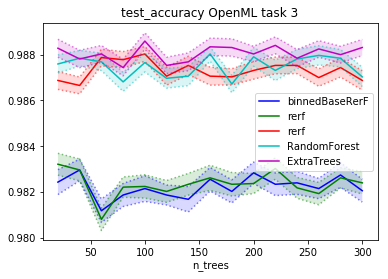

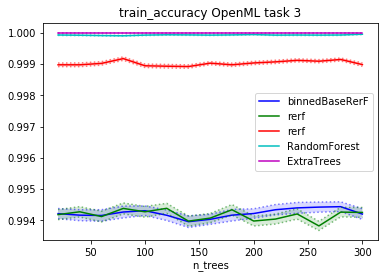

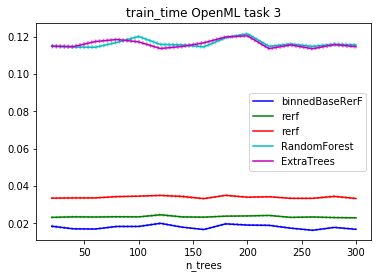

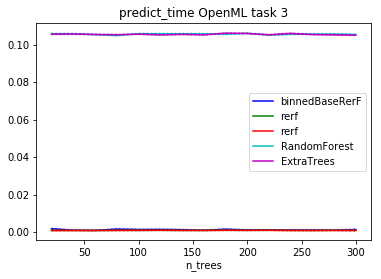

In [5]:
# Plots the results
# If save == True then saves the images to filename_title.png for each plot
results = OpenML_benchmark_plot([averages, std_errs],
                            param_values=param_values,
                            all_forests=all_forests, 
                            titles=['test_accuracy', 'train_accuracy', 'train_time', 'predict_time'],
                            task_id=3, 
                            param='n_trees', 
                            save=True,
                            filename='oml_task_3_no_preprocessing'
                    )